In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import gitsummary
print(gitsummary.print_cwd_git_version())
import socket; print(f"Running on: {socket.getfqdn()}")

No git repository detected.
Running on: login22.chn


# ERA5 - TECA BARD v1.0.1

This section uses TECA BARD to determine unambiguous AR presence over Bloomington, IN.

In [2]:
""" Open the TECA ARTMIP files """

file_glob = f"/global/cfs/cdirs/m4374/user_work_directories/taobrien/teca_bard_era5_redo/teca_bard_era5/ERA5_BARD_AR.*.nc4"

# open the dataset
teca_xr = xr.open_mfdataset(file_glob)

# select times that overlap with MERRA2; also subset to 3-hourly
teca_xr = teca_xr.sel(time = slice('1980-01-01', '2017-06-30')).isel(time = slice(0, None, 3))
teca_xr

<xarray.Dataset>
Dimensions:              (time: 109568, latitude: 721, longitude: 1440,
                          dim_ar_count: 1024, dim_parameter_table_row: 1024)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 2017-06-30T21:0...
  * latitude             (latitude) float64 -90.0 -89.75 -89.5 ... 89.75 90.0
  * longitude            (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
Dimensions without coordinates: dim_ar_count, dim_parameter_table_row
Data variables:
    ar_probability       (time, latitude, longitude) float32 dask.array<chunksize=(248, 721, 1440), meta=np.ndarray>
    ar_binary_tag        (time, latitude, longitude) int8 dask.array<chunksize=(248, 721, 1440), meta=np.ndarray>
    ar_count             (time, dim_ar_count) int32 dask.array<chunksize=(248, 1024), meta=np.ndarray>
    parameter_table_row  (time, dim_parameter_table_row) int32 dask.array<chunksize=(248, 1024), meta=np.ndarray>
Attributes:
    TECA_version:   5.0.0-312-g1505762
    TECA_app_name:  teca_bayesian_ar_detect

In [3]:
""" Pull out a point over Bloomington """
blat, blon = 39.1653, -86.5264 + 360

teca_bloomington = teca_xr.sel(latitude = blat, longitude = blon, method = 'nearest')
teca_bloomington['indices'] = xr.DataArray(np.arange(0,len(teca_bloomington.time), dtype = int), dims = ('time',))
teca_bloomington.load()

<xarray.Dataset>
Dimensions:              (time: 109568, dim_ar_count: 1024,
                          dim_parameter_table_row: 1024)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 2017-06-30T21:0...
    latitude             float64 39.25
    longitude            float64 273.5
Dimensions without coordinates: dim_ar_count, dim_parameter_table_row
Data variables:
    ar_probability       (time) float32 0.0 0.0 0.0 0.0 ... 0.8799 0.8408 0.8594
    ar_binary_tag        (time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 1 1 1 1 1 1 1 1 1
    ar_count             (time, dim_ar_count) int32 9 11 9 8 11 ... 12 10 12 12
    parameter_table_row  (time, dim_parameter_table_row) int32 972 974 ... 1022
    indices              (time) int64 0 1 2 3 4 ... 109564 109565 109566 109567
Attributes:
    TECA_version:   5.0.0-312-g1505762
    TECA_app_name:  teca_bayesian_ar_detect


## Comparison with MERRA2 AR times

In [4]:
""" Open the MERRA2 AR detection file. """
merra2_inds = np.loadtxt("./merra2_index_files/bloomington_ars_annual_teca_bard_v1.0.1.txt", dtype = int)

#
tecaera5_at_merra2_times = teca_bloomington.isel(time = merra2_inds)


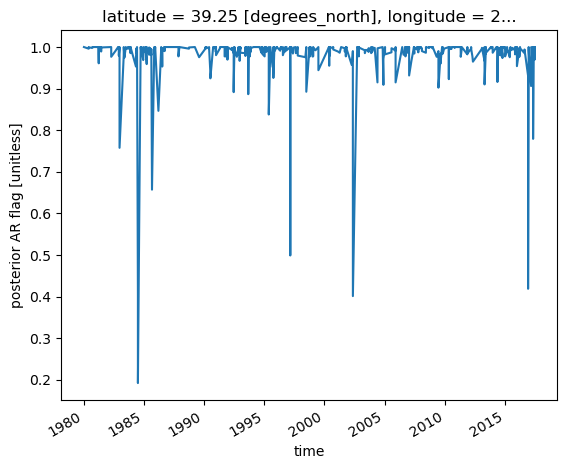

In [5]:
e5arprob_at_merra2_times = tecaera5_at_merra2_times['ar_probability']

e5arprob_at_merra2_times.plot()

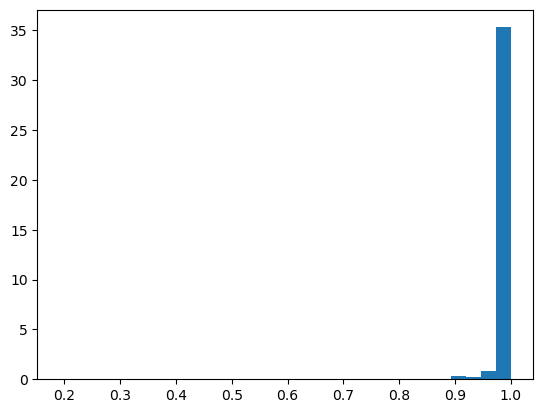

In [6]:
""" Plot a histogram of the AR probability """
import matplotlib.pyplot as plt
plt.hist(e5arprob_at_merra2_times, bins = 30, density = True)
plt.show()

In [7]:
""" Find times with unambiguous AR conditions """

bloomington_ar = teca_bloomington.where(teca_bloomington['ar_probability'] == 1, drop = True)
bloomington_ar

<xarray.Dataset>
Dimensions:              (time: 654, dim_ar_count: 1024,
                          dim_parameter_table_row: 1024)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-11T09:00:00 ... 2017-0...
    latitude             float64 39.25
    longitude            float64 273.5
Dimensions without coordinates: dim_ar_count, dim_parameter_table_row
Data variables:
    ar_probability       (time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ar_binary_tag        (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ar_count             (time, dim_ar_count) float64 10.0 10.0 10.0 ... 8.0 8.0
    parameter_table_row  (time, dim_parameter_table_row) float64 976.0 ... 1....
    indices              (time) float64 83.0 1.227e+03 ... 1.095e+05 1.095e+05
Attributes:
    TECA_version:   5.0.0-312-g1505762
    TECA_app_name:  teca_bayesian_ar_detect

In [8]:
""" Find only times in specific seasons """

bloomington_ar_season = {}
for season in ['DJF','MAM','JJA','SON']:
    bloomington_ar_season[season] = bloomington_ar.where(bloomington_ar['time.season'] == season, drop = True)
    # load the dataset
    bloomington_ar_season[season].load()
bloomington_ar_season['annual'] = bloomington_ar    

In [9]:
""" Write the indices to disk """
algorithm = "teca_bard_v1.0.1"
output_dir = "era5_sensitivity_study"
import os
os.makedirs(output_dir, exist_ok = True)
for season in bloomington_ar_season:
    indices = bloomington_ar_season[season]['indices'].values
    np.savetxt(f"{output_dir}/era5_like_merra2_bloomington_ars_{season}_{algorithm}.txt",indices,fmt = "%i")

# ERA5

This section converts the MERRA2 indices to indices in ERA5, assuming that the dataset is opened from 1979-01-01 00Z at hourly resolution, with time indices increasing linearly.

In [10]:
""" Create a time axis representing ERA5 """
e5_times = pd.DataFrame(dict(time = pd.date_range('1979-01-01 00:00:00', '2021-12-01 00:00:00', freq = '1H')))
e5_times = e5_times.reindex(e5_times['time'])#.to_xarray()
e5_times['time'] = e5_times.index
e5_times = e5_times.to_xarray()
e5_times['indices'] = xr.DataArray(np.arange(0,len(e5_times.time), dtype = int), dims = ('time',))
e5_times

<xarray.Dataset>
Dimensions:  (time: 376201)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2021-12-01
Data variables:
    indices  (time) int64 0 1 2 3 4 5 ... 376196 376197 376198 376199 376200

In [11]:
""" Convert to ERA5 indices and save. """
for season in bloomington_ar_season:
    e5_indices = e5_times.sel(time = bloomington_ar_season[season].time)['indices'].values
    np.savetxt(f"{output_dir}/bloomington_ars_{season}_era5_{algorithm}.txt",e5_indices,fmt = "%i")